    0.Importing Packages

In [153]:
#Importing necessary libraries
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import random
import gym
import numpy as np
from collections import deque
from tensorflow.keras.models import Model, load_model,Sequential
from tensorflow.keras.layers import Input, Dense,Flatten
from tensorflow.keras.optimizers import Adam, RMSprop
import matplotlib.pyplot as plt

C:\Users\fayas\Anaconda3\envs\tf\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


    1. Importing an Open AI Gym Game

In [154]:
# Importing the cartpole environment from openAi gym
env = gym.make('CartPole-v0')
actions = env.action_space.n
states = env.observation_space.shape[0]

C:\Users\fayas\Anaconda3\envs\tf\lib\site-packages\gym\envs\registration.py:506: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1` with the environment ID `CartPole-v1`.
  f"The environment {path} is out of date. You should consider "


Random Test with the imported OpenAi Gym game

In [155]:
# testing the environment with random actions
episodes = 100
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    
    while not done:
        env.render()
        action = random.choice([0,1])
        n_state, reward, done, info = env.step(action)
        score+=reward
    print('Episode:{} Score:{}'.format(episode, score))

Episode:1 Score:16.0
Episode:2 Score:11.0
Episode:3 Score:12.0
Episode:4 Score:14.0
Episode:5 Score:10.0
Episode:6 Score:14.0
Episode:7 Score:20.0
Episode:8 Score:19.0
Episode:9 Score:12.0
Episode:10 Score:37.0
Episode:11 Score:11.0
Episode:12 Score:14.0
Episode:13 Score:13.0
Episode:14 Score:14.0
Episode:15 Score:17.0
Episode:16 Score:30.0
Episode:17 Score:17.0
Episode:18 Score:15.0
Episode:19 Score:28.0
Episode:20 Score:22.0
Episode:21 Score:18.0
Episode:22 Score:13.0
Episode:23 Score:32.0
Episode:24 Score:17.0
Episode:25 Score:10.0
Episode:26 Score:14.0
Episode:27 Score:10.0
Episode:28 Score:36.0
Episode:29 Score:16.0
Episode:30 Score:15.0
Episode:31 Score:19.0
Episode:32 Score:26.0
Episode:33 Score:12.0
Episode:34 Score:17.0
Episode:35 Score:18.0
Episode:36 Score:9.0
Episode:37 Score:15.0
Episode:38 Score:22.0
Episode:39 Score:13.0
Episode:40 Score:19.0
Episode:41 Score:11.0
Episode:42 Score:16.0
Episode:43 Score:66.0
Episode:44 Score:22.0
Episode:45 Score:14.0
Episode:46 Score:13.

    2. Creating a Network

In [156]:
# creating a neural network model with keras
def neural_model(states, actions):
    X_input = Input(states)
    model = Sequential()
    model.add(Flatten(input_shape=states))
    #model.add(Dense(512, activation='relu'))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    model.compile(loss='mse',optimizer=Adam(learning_rate=0.001))

    return model

In [157]:
# creating a model object
model = neural_model((states,), actions)

In [158]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 4)                 0         
_________________________________________________________________
dense_18 (Dense)             (None, 24)                120       
_________________________________________________________________
dense_19 (Dense)             (None, 24)                600       
_________________________________________________________________
dense_20 (Dense)             (None, 2)                 50        
Total params: 770
Trainable params: 770
Non-trainable params: 0
_________________________________________________________________


    3.Connecting game to the network

In [159]:
# Hyperparameters for the DQN algorithm
EPISODES = 300

EXPLORATION_MAX= 1.0
EXPLORATION_MIN = 0.001
EXPLORATION_DECAY = 0.999

GAMMA = 0.95
LEARNING_RATE = 0.001

MEMORY_SIZE = 10000
BATCH_SIZE = 64

TRAIN_START = 1000

In [160]:
# defining the class for the DQN algorithm
class DQNSolver:
    
    ''' Deep Q Neural Network class. '''

    #initializing the model parameters
    def __init__(self, states, actions,model):
        self.exp_rate = EXPLORATION_MAX
        self.action_choice = actions
        self.memory = deque(maxlen=MEMORY_SIZE)
        self.model = model

    # appending the values to the memory table
    def DQN_table(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        if len(self.memory) > TRAIN_START:
            if self.exp_rate > EXPLORATION_MIN:
                self.exp_rate *= EXPLORATION_DECAY


    # play function to choose the action based on exploration rate
    def play(self, state):
        if np.random.rand() < self.exp_rate:
            return random.randrange(self.action_choice)
        q_val = self.model.predict(state)
        return np.argmax(q_val[0])

    # defining the experience_replay function to store the experience in the memory
    def experience_replay(self):
        if len(self.memory) < TRAIN_START:
            return
        batch = random.sample(self.memory, BATCH_SIZE)
        for state, action, reward, next_state, terminal in batch:
            qval_update = reward
            if not terminal:
                qval_update = (reward + GAMMA * np.amax(self.model.predict(next_state)[0]))
            q_val = self.model.predict(state)
            q_val[0][action] = qval_update
            self.model.fit(state, q_val, verbose=0)
        self.exp_rate *= EXPLORATION_DECAY
        self.exp_rate = max(EXPLORATION_MIN, self.exp_rate)

    # function to save the model    
    def save(self,name):
         
         self.model.save(name)

In [161]:
# list variables to store the values for plotting
plotScores=[]
plotepsilon=[] 
plotsteps = []

In [162]:
# Training the DQN algorithm
def training():
    
    dqn_solver = DQNSolver(states, actions,model)
    run = 0
    for run in range(EPISODES):
        score = 0
        state = env.reset()
        state = np.reshape(state, [1, states])
        iter = 0
        terminal = False
        while not terminal:
            iter += 1
            env.render()
            action = dqn_solver.play(state)
            next_state, reward, terminal, info = env.step(action)
            reward = reward if not terminal else -100
            score += reward
            next_state = np.reshape(next_state, [1, states])
            dqn_solver.DQN_table(state, action, reward, next_state, terminal)
            state = next_state
            if terminal:
                plotScores.append(score)
                #plotScores.append(iter)
                plotepsilon.append(dqn_solver.exp_rate)
                plotsteps.append(run)
                print ("Run: " + str(run) + " / " + str(EPISODES) + ", exploration: " + str(dqn_solver.exp_rate)+ ", score:"  + str(score))
                if run == 100 or run == 299 or run == 1000:
                    print("Saving trained model as cartpole_weights"+str(run)+".h5")
                    dqn_solver.save('cartpole_weights'+str(run)+'.h5')
                break
            dqn_solver.experience_replay()
        
    return plotScores,plotepsilon,plotsteps 

In [163]:
plotScores,plotepsilon,plotsteps = training()

Run: 0 / 300, exploration: 1.0, score:-80.0
Run: 1 / 300, exploration: 1.0, score:-65.0
Run: 2 / 300, exploration: 1.0, score:-64.0
Run: 3 / 300, exploration: 1.0, score:-85.0
Run: 4 / 300, exploration: 1.0, score:-87.0
Run: 5 / 300, exploration: 1.0, score:-92.0
Run: 6 / 300, exploration: 1.0, score:-89.0
Run: 7 / 300, exploration: 1.0, score:-84.0
Run: 8 / 300, exploration: 1.0, score:-91.0
Run: 9 / 300, exploration: 1.0, score:-83.0
Run: 10 / 300, exploration: 1.0, score:-54.0
Run: 11 / 300, exploration: 1.0, score:-89.0
Run: 12 / 300, exploration: 1.0, score:-82.0
Run: 13 / 300, exploration: 1.0, score:-79.0
Run: 14 / 300, exploration: 1.0, score:-61.0
Run: 15 / 300, exploration: 1.0, score:-81.0
Run: 16 / 300, exploration: 1.0, score:-83.0
Run: 17 / 300, exploration: 1.0, score:-88.0
Run: 18 / 300, exploration: 1.0, score:-25.0
Run: 19 / 300, exploration: 1.0, score:-90.0
Run: 20 / 300, exploration: 1.0, score:-81.0
Run: 21 / 300, exploration: 1.0, score:-68.0
Run: 22 / 300, explo

In [ ]:
plotScores

[-84.0,
 -72.0,
 -79.0,
 -78.0,
 -73.0,
 -84.0,
 -65.0,
 -86.0,
 -70.0,
 -66.0,
 -85.0,
 -75.0,
 -69.0,
 -76.0,
 -64.0,
 -80.0,
 -62.0,
 -88.0,
 -71.0,
 -79.0,
 -69.0,
 -78.0,
 -76.0,
 -73.0,
 -53.0,
 -89.0,
 -84.0,
 -87.0,
 -91.0,
 -87.0,
 -90.0,
 -85.0,
 -85.0,
 -80.0,
 -62.0]

    4. Implementing the deep reinforcement learning model

In [ ]:
# Load the model
def load(name):
        return load_model(name)

In [ ]:
#test the model with our trained model weights
def testing(state_size):
    load('cartpole_weights29.h5')
    for run in range(EPISODES):
        state = env.reset()
        state = np.reshape(state, [1,state_size])
        terminal = False
        score = 0
        iter = 0
        while not terminal:
            iter += 1
            env.render()
            action = np.argmax(model.predict(state))
            next_state, reward, terminal, info = env.step(action)
            score += reward
            state = np.reshape(next_state, [1, state_size])
            if done:
                print ("Run: " + str(run) + " / " + str(EPISODES) + ", score: " + str(score))
                break

In [ ]:
testing(states)

Run: 0 / 35, score: 1.0
Run: 1 / 35, score: 1.0
Run: 2 / 35, score: 1.0
Run: 3 / 35, score: 1.0
Run: 4 / 35, score: 1.0
Run: 5 / 35, score: 1.0
Run: 6 / 35, score: 1.0
Run: 7 / 35, score: 1.0
Run: 8 / 35, score: 1.0
Run: 9 / 35, score: 1.0
Run: 10 / 35, score: 1.0
Run: 11 / 35, score: 1.0
Run: 12 / 35, score: 1.0
Run: 13 / 35, score: 1.0
Run: 14 / 35, score: 1.0
Run: 15 / 35, score: 1.0
Run: 16 / 35, score: 1.0
Run: 17 / 35, score: 1.0
Run: 18 / 35, score: 1.0
Run: 19 / 35, score: 1.0
Run: 20 / 35, score: 1.0
Run: 21 / 35, score: 1.0
Run: 22 / 35, score: 1.0
Run: 23 / 35, score: 1.0
Run: 24 / 35, score: 1.0
Run: 25 / 35, score: 1.0
Run: 26 / 35, score: 1.0
Run: 27 / 35, score: 1.0
Run: 28 / 35, score: 1.0
Run: 29 / 35, score: 1.0
Run: 30 / 35, score: 1.0
Run: 31 / 35, score: 1.0
Run: 32 / 35, score: 1.0
Run: 33 / 35, score: 1.0
Run: 34 / 35, score: 1.0


In [ ]:
#plotting the rewards and epsilon values vs episodes

def plot_learning_curves(x, scores,epsilons, filename, lines=None):
    fig=plt.figure(figsize=(15,10))
    ax=fig.add_subplot(121, label="1")
    ax2=fig.add_subplot(122, label="2")
        

    ax.plot(x, epsilons, color="C0")
    ax.set_xlabel("Training Steps", color="C0")
    ax.set_ylabel("Epsilon", color="C0")
    ax.tick_params(axis='x', colors="C0")
    ax.tick_params(axis='y', colors="C0")
    ax.grid()
    N = len(scores)
    running_avg = np.empty(N)
    for t in range(N):
	    running_avg[t] = np.mean(scores[max(0, t-20):(t+1)])

    ax2.scatter(x, running_avg, color="C1")
    ax2.set_xlabel("Training Steps", color="C0")
    ax2.yaxis.tick_right()
    ax2.set_ylabel('Score', color="C1")
    ax2.yaxis.set_label_position('right')
    ax2.tick_params(axis='x', colors="C0")
    ax2.tick_params(axis='y', colors="C1")
    ax2.grid()
    if lines is not None:
        for line in lines:
            plt.axvline(x=line)

    plt.savefig(filename)

In [ ]:
plotFigure = 'plot1'

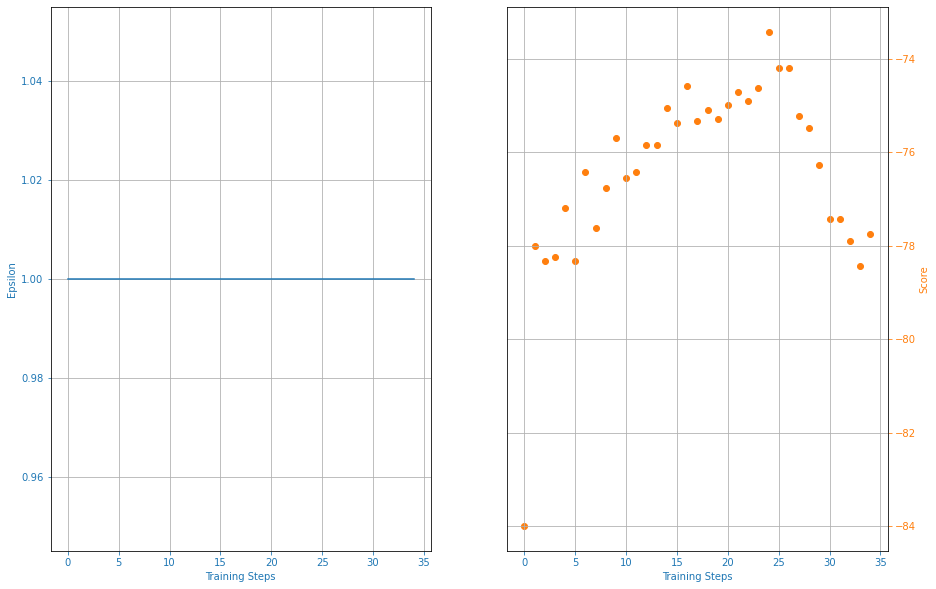

In [ ]:
plot_learning_curves(plotsteps, plotScores, plotepsilon, plotFigure)